In [3]:
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cbpro

public_client = cbpro.PublicClient()


In [6]:
class MinerMeta(type):
    def compile_historic(self):
        start_date = datetime(2020, 1, 1)
        end_date = datetime.today()
        delta = timedelta(hours=300)
        df = pd.DataFrame()

        while start_date <= end_date:
            historic = public_client.get_product_historic_rates(
                f"{self.coin}-USD",
                granularity=3600,
                start=start_date,
                end=start_date + delta,
            )
            start_date += delta
            df = df.append(historic)
        df.columns = ["time", "low", "high", "open", "close", "volume"]
        date_time = pd.to_datetime(df["time"], unit="s")

        timestamp_s = date_time.map(pd.Timestamp.timestamp)
        day = 24 * 60 * 60
        year = (365.2425) * day
        df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
        df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
        df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
        df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
        # df["time"] = pd.to_datetime(df["time"], unit="s")
        # df["time"] = date_time.map(pd.Timestamp.timestamp)

        # data = np.array(df, dtype=np.float32)
        # ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        #     data=df,
        #     targets="close",
        #     sequence_length=10,
        #     sequence_stride=1,
        #     shuffle=False,
        #     batch_size=64,
        # )

        return df

    def plot_cols(self, cols=None):
        df = self.compile_historic()
        if cols == None:
            plot_features = df[list(df.columns)]
        else:
            plot_features = df[cols]
        plot_features.index = df["time"]
        return plot_features.plot(subplots=True)

    def do_fft(self):
        df = self.compile_historic()
        fft = tf.signal.rfft(df["close"])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = len(df["close"])
        hours_per_year = 24 * 365.2524
        years_per_dataset = n_samples_h / (hours_per_year)

        f_per_year = f_per_dataset / years_per_dataset
        plt.step(f_per_year, np.abs(fft))
        plt.xscale("log")
        plt.ylim(0, 400000)
        plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
        return plt.xlabel("Frequency (log scale)")

    # def make_dataset(data):
    #     data = np.array(data, dtype=np.float32)
    #     ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    #         data=data,
    #         targets="close",
    #         sequence_length=10,
    #         sequence_stride=1,
    #         shuffle=False,
    #         batch_size=64,
    #     )

    #     return ds

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        setattr(cls, "compile_historic", self.compile_historic)
        setattr(cls, "plot_cols", self.plot_cols)
        setattr(cls, "do_fft", self.do_fft)
        # setattr(cls, "make_dataset", self.compile_historic)

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


class eth(metaclass=MinerMeta):
    coin = "eth"


class btc(metaclass=MinerMeta):
    coin = "btc"


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

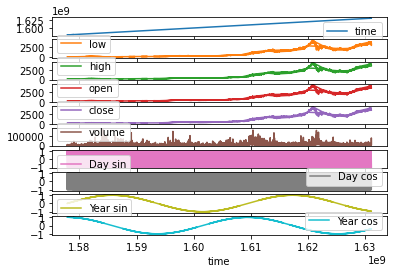

In [7]:
eth = eth()

eth.plot_cols()


In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers
    
    def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call


